In [1]:
import tqdm
import torch, cv2
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from torchvision.ops import box_iou
import sys
sys.path.append('../scripts/')
from resize_boxes import resize_values
from tqdm import tqdm
import time
import pickle
import PIL

In [2]:
image_paths = np.loadtxt('../../bird_dataset/CUB_200_2011/images.txt', dtype=str) # all image paths
bboxes_file_path = "../../bird_dataset/CUB_200_2011/bounding_boxes.txt"
bboxes = np.loadtxt(bboxes_file_path, dtype=int, delimiter=" ", ndmin=2)[:, 1:] # Take only x, y, w, h 
# bboxes[:, 2] = bboxes[:, 2] + bboxes[:, 0] # get corner point
# bboxes[:, 3] = bboxes[:, 3] + bboxes[:, 1] # get corner point

/tmp/ipykernel_4978/3739098993.py:3: DeprecationWarning: loadtxt(): Parsing an integer via a float is deprecated.  To avoid this warning, you can:
    * make sure the original data is stored as integers.
    * use the `converters=` keyword argument.  If you only use
      NumPy 1.23 or later, `converters=float` will normally work.
    * Use `np.loadtxt(...).astype(np.int64)` parsing the file as
      floating point and then convert it.  (On all NumPy versions.)
  (Deprecated NumPy 1.23)
  bboxes = np.loadtxt(bboxes_file_path, dtype=int, delimiter=" ", ndmin=2)[:, 1:] # Take only x, y, w, h


In [3]:
bboxes[:, 2] = bboxes[:, 0] + bboxes[:, 2]
bboxes[:, 3] = bboxes[:, 1] + bboxes[:, 3]

In [21]:
updated_boxes = []
for x in tqdm(range(len(image_paths))):
    # print('../../data/CUB_200_2011/images/'+ image_paths[x][1])
    img = np.array(PIL.Image.open('../../bird_dataset/CUB_200_2011/images/'+ image_paths[x][1]))
    updated_boxes.append(resize_values(bboxes[x], img.shape, (416, 416), return_old_box=False))

100%|██████████| 11788/11788 [00:39<00:00, 299.23it/s]


In [22]:
updated_boxes[0]

[49.92, 33.528358208955225, 320.32, 411.0328358208955]

In [66]:
bboxes[0]

array([ 60,  27, 445, 331])

In [83]:
temp = '../../bird_dataset/CUB_200_2011/images/' + image_paths[1][1]

In [84]:
bboxes[1]

array([139,  30, 292, 294])

In [77]:
# 325 + 60 = 385
# 304 + 27 = 331

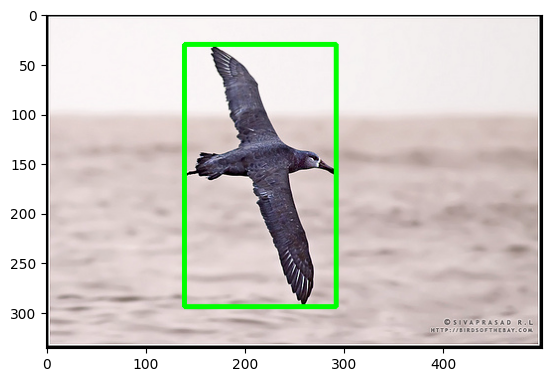

In [85]:
img_ = cv2.imread(temp)
img = cv2.rectangle(img_, (139, 30), (292, 294), (0, 255, 0), 3)
plt.imshow(img)

In [89]:
img_ = cv2.imread(temp)
img_ = cv2.resize(img_, (416, 416))

In [93]:
updated_boxes[0]

[49.92, 33.528358208955225, 270.40000000000003, 377.50447761194033]

In [103]:
bboxes[0]

array([ 60,  27, 385, 331])

In [110]:
x1, y1, x2, y2 = 60, 27, 385, 331
x1_o = x1 / 500
y1_o = y1 / 335
x2_o = x2 / 500
y2_o = y2 / 335
x1_n = 416 * x1_o
y1_n = 416 * y1_o
x2_n = 416 * x2_o
y2_n = 416 * y2_o

In [5]:
updated_boxes[0]

[49.92, 33.528358208955225, 320.32, 411.0328358208955]

In [111]:
print(x1_n)
print(y1_n)
print(x2_n)
print(y2_n)

49.92
33.528358208955225
320.32
411.0328358208955


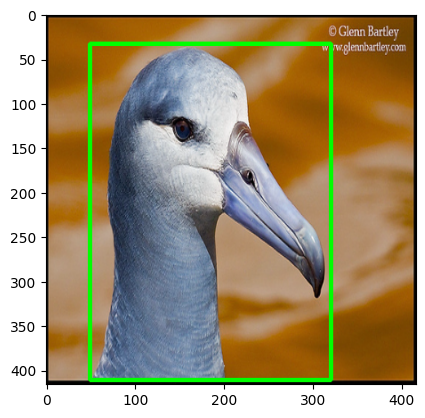

In [6]:
temp = '../../bird_dataset/CUB_200_2011/images/' + image_paths[0][1]
img_ = cv2.imread(temp)
img_ = cv2.resize(img_, (416, 416))
# img = cv2.rectangle(img_, (int(updated_boxes[0][0]), int(updated_boxes[0][1])), (int(updated_boxes[0][2]), int(updated_boxes[0][3])), (0, 255, 0), 3)
img_ = cv2.rectangle(img_, (int(updated_boxes[0][0]), int(updated_boxes[0][1])), (int(updated_boxes[0][2]), int(updated_boxes[0][3])), (0, 255, 0), 3)
plt.imshow(img_)

In [23]:
updated_boxes_v1 = updated_boxes.copy()

In [24]:
updated_boxes_v1 = torch.Tensor(updated_boxes_v1)

In [25]:
def IoU(clusters: torch.tensor, bboxes: torch.tensor):
    iou_values = box_iou(clusters, bboxes)
    return iou_values

In [26]:
def KMeans(bboxes:torch.tensor, k:int, dist=torch.mean, stop_iter=5):
    rows = bboxes.shape[0]
    distances = torch.empty((rows, k))
    last_clusters = torch.zeros((rows, ))

#   We will randomly pick them and tell them they are the cluster centroids.....
    cluster_indxs = np.random.choice(rows, k, replace=False) # choose unique indexs in rows
    clusters = bboxes[cluster_indxs].clone()

    iteration = 0
    while True:
        # calculate the distances 
        distances = IoU(bboxes, clusters)

        nearest_clusters = torch.argmax(distances, dim=1) # 0, 1, 2 ... K   

        if (last_clusters == nearest_clusters).all(): # break if nothing changes
            iteration += 1
            if iteration == stop_iter:
                break
        else:
            iteration = 0
        # Take the mean and step for cluster coordiantes 
        for cluster in range(k):
            clusters[cluster] = torch.mean(bboxes[nearest_clusters == cluster], axis=0)

        last_clusters = nearest_clusters.clone()
    return clusters, distances

In [27]:
clusterList = [1, 2, 3, 4, 5]
mean_distances, anchorBoxes = [], []

for cluster_k in tqdm(clusterList):
    anchors, distances = KMeans(updated_boxes_v1, k=cluster_k)
    indxs = torch.argmax(distances, dim=1)
    filtered_distances = []
    for i, distance in enumerate(distances):
        filtered_distances.append(distance[indxs[i]].item())
    mean_distances.append(np.mean(filtered_distances))
    anchorBoxes.append(anchors)

100%|██████████| 5/5 [00:09<00:00,  1.99s/it]


Text(0, 0.5, 'IoU score')

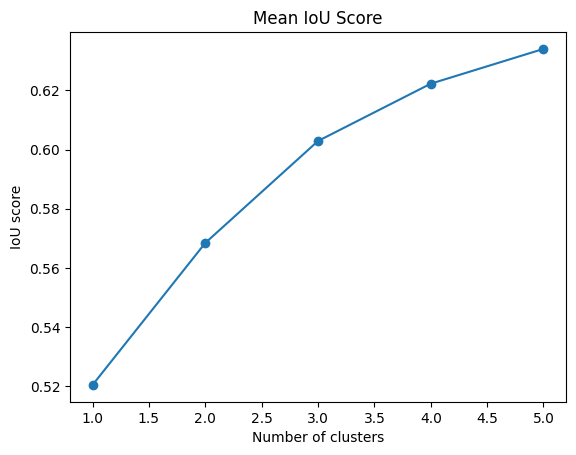

In [28]:
plt.plot(clusterList, mean_distances)
plt.scatter(clusterList, mean_distances)
plt.title("Mean IoU Score")
plt.xlabel("Number of clusters")
plt.ylabel("IoU score")

In [ ]:
with open('./mean_dist.pkl', 'wb') as handle:
    pickle.dump(mean_distances, handle)
with open('./anchor_boxes.pkl', 'wb') as handle:
    pickle.dump(anchorBoxes, handle)

In [30]:
anchorBoxes

[tensor([[ 91.7113,  89.8630, 321.8488, 340.7087]]),
 tensor([[ 93.7793, 110.8524, 261.0897, 318.5800],
         [ 90.7260,  79.8625, 350.7976, 351.2520]]),
 tensor([[156.4379, 112.8638, 333.3705, 321.8702],
         [ 65.4563,  69.4734, 348.8846, 359.9174],
         [ 83.6566, 110.2138, 253.8614, 318.7748]]),
 tensor([[131.2842, 109.9955, 280.0103, 313.8150],
         [156.9488, 109.4453, 356.6765, 330.7996],
         [ 61.0666,  66.3282, 353.4342, 360.8148],
         [ 59.9887, 105.6424, 252.3022, 329.1073]]),
 tensor([[ 57.5417,  65.5432, 357.4023, 362.1443],
         [131.7946, 133.3458, 277.2348, 290.0606],
         [ 55.7862, 106.2911, 251.7348, 327.5038],
         [158.0904, 110.1830, 360.6002, 330.2718],
         [120.8317,  86.2234, 290.7593, 341.1542]])]